# Research on car sales ads <a name="introduction"></a>

You're an analyst at Crankshaft List. Hundreds of free advertisements for vehicles are published on your site every day.

You need to study data collected over the last few years and determine which factors influence the price of a vehicle. 

### Step 1: Open data file & look at general info <a name="step_1"></a>

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# try-except block handles errors that occur from changing file directories
try:
    data = pd.read_csv('vehicles_us.csv')
except:
    data = pd.read_csv('/datasets/vehicles_us.csv')


# print first 10 rows of data    
data.head(10)

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28
5,14990,2014.0,chrysler 300,excellent,6.0,gas,57954.0,automatic,sedan,black,1.0,2018-06-20,15
6,12990,2015.0,toyota camry,excellent,4.0,gas,79212.0,automatic,sedan,white,NaN,2018-12-27,73
7,15990,2013.0,honda pilot,excellent,6.0,gas,109473.0,automatic,SUV,black,1.0,2019-01-07,68
8,11500,2012.0,kia sorento,excellent,4.0,gas,104174.0,automatic,SUV,NaN,1.0,2018-07-16,19
9,9200,2008.0,honda pilot,excellent,NaN,gas,147191.0,automatic,SUV,blue,1.0,2019-02-15,17


In [2]:
# print general information & statistics about the data

data.info()
print('')
print('')
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    47906 non-null  float64
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     46265 non-null  float64
 5   fuel          51525 non-null  object 
 6   odometer      43633 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   42258 non-null  object 
 10  is_4wd        25572 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB


               price    model_year     cylinders       odometer   is_4wd  \
count   51525.000000  47906.000000  46265.000000   43633.000000  25572.0   
mean    12132.464920   2009.75

#### Conclusion <a name="step_1_conclusion"></a>

The **model_year**, **cylinder**, **odometer**, **paint_color**, and **is_4wd** columns all have missing or erroneous values that we need to address and fill. For missing values in the **model_year** column, we can use the most common year for each model. For missing values in the **cylinders** column, we can use the number of cylinders given by other rows for the same model. Missing values in the **odometer** column can be set to the average mileage based on the model year. For the **paint_color** column, we can use the most common paint colors for certain models. It appears as if the missing values in **is_4wd** should all be 0 or False values, so we can fill these with zeros.

We should also change data types for some columns. The **model_year**, **cylinders**, and **odometer** columns should be changed from *float64* to *int64* since they don't require decimal precision. The **date_posted** column data type should be changed from *object* to *datetime*.

### Step 2: Data preprocessing <a name="step_2"></a>

#### Processing missing values <a name="step_2_1"></a>

We'll start with missing values in the **model_year**, **cylinders**, and **paint_color** columns. We can use the most common model years, number of cylinders, and paint colors for each model and then fill missing values in each column based on model accordingly. We'll write a function to achieve this.

In [3]:
# write a function that replaces NaNs in a column with most common occurrences of that data based on the vehicle model

def fillna_modes(model, nan_col):
    """Take model column and column containing NaNs
    and fill NaN column with modes based on model"""
    
    model_modes = data.groupby(model)[nan_col].agg(lambda x: x.value_counts().index[0])
    model_modes_dict = dict(zip(model_modes.index, model_modes.values))
    data[nan_col] = data[nan_col].fillna(data[model].map(model_modes_dict))

fillna_modes('model', 'model_year')
fillna_modes('model', 'cylinders')
fillna_modes('model', 'paint_color')

Next, we'll do something similar with the **odometer** column. Rather than using the mode and vehicle model, we'll use the average based on vehicle year.

In [4]:
# replace NaNs in the 'odometer' column with the mean mileage based on the model year

year_means = data.groupby('model_year')['odometer'].mean()
year_means_dict = dict(zip(year_means.index, year_means.values))
data['odometer'] = data['odometer'].fillna(data['model_year'].map(year_means_dict))

In [5]:
# check for any other NaNs in the 'odometer' column

data[data['odometer'].isna()]

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
45694,18000,1929.0,ford f-150,good,8.0,gas,NaN,manual,other,silver,NaN,2018-11-18,59


There's still one vehichle with a missing value in the **odometer** column, a 1929 Ford F-150. We can fill this with the odometer average for the next closest model year.

In [6]:
# look at the next closest model year and find the odometer reading

data.sort_values(by='model_year').head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
33906,12995,1908.0,gmc yukon,good,8.0,gas,169328.0,automatic,SUV,black,NaN,2018-07-06,34
33907,12995,1908.0,cadillac escalade,excellent,8.0,gas,169328.0,automatic,SUV,white,NaN,2018-06-24,25
45694,18000,1929.0,ford f-150,good,8.0,gas,NaN,manual,other,silver,NaN,2018-11-18,59
34713,5000,1936.0,ford f-150,excellent,6.0,gas,30000.0,manual,pickup,purple,NaN,2018-11-22,10
22595,21000,1948.0,chevrolet impala,like new,8.0,gas,4000.0,automatic,sedan,red,NaN,2019-01-18,24


We can use the average for the 1908 model year as an estimate for our last missing value. 1908 vehicle models averaged 169,328 miles. Let's use .loc to replace the last NaN with this average value.

In [7]:
# replace 1929 F-150 odometer value with 169,328

data.loc[data['model_year'] == 1929, 'odometer'] = 169328

The **odometer** column now has no missing values. That leaves us with the **is_4wd** column, which consists of 1s and NaNs. Here, missing values can be safely replaced with 0s, indicating that the vehicle is not 4wd.

In [8]:
# replace NaN values in 'is_4wd' with 0s

data['is_4wd'] = data['is_4wd'].fillna(0)

In [9]:
# make sure that all missing values have been filled

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    51525 non-null  float64
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     51525 non-null  float64
 5   fuel          51525 non-null  object 
 6   odometer      51525 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   51525 non-null  object 
 10  is_4wd        51525 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB


#### Checking for duplicates <a name="step_2_2"></a>

It's always a good idea to check for and address duplicates. We can't see anything immediately that would suggest there are duplicates, but it's good practice to check with the .duplicated() pandas method.

In [10]:
# add up number of rows containing duplicates

data.duplicated().sum()

0

There are no duplicates in the data. Next, we can change data types of some of the columns to more appropriate types.

#### Changing data types <a name="step_2_3"></a>
All of the *float64* data types should be changed to *int64* since decimal points are unnecessary here. We should also change the **date_posted** data from *object* to *datetime* to make it easier to work with.

In [11]:
# define list of columns to set from float type to int64 type and change type with .astype() method

float_cols = ['model_year', 'cylinders', 'odometer', 'is_4wd']
data[float_cols] = data[float_cols].astype('int64')

In [12]:
# use .to_datetime method to change 'date_posted' column to datetime data type

data['date_posted'] = pd.to_datetime(data['date_posted'], format='%Y-%m-%d')

In [13]:
# check final results after replacing mising values and changing data types

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         51525 non-null  int64         
 1   model_year    51525 non-null  int64         
 2   model         51525 non-null  object        
 3   condition     51525 non-null  object        
 4   cylinders     51525 non-null  int64         
 5   fuel          51525 non-null  object        
 6   odometer      51525 non-null  int64         
 7   transmission  51525 non-null  object        
 8   type          51525 non-null  object        
 9   paint_color   51525 non-null  object        
 10  is_4wd        51525 non-null  int64         
 11  date_posted   51525 non-null  datetime64[ns]
 12  days_listed   51525 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(6)
memory usage: 5.1+ MB


#### Conclusion <a name="step_2_conclusion"></a>

We used the most common model years, number of cylinders, and paint colors for each model and then filled missing values in each column based on model accordingly unsing a function. For the **is_4wd** column, missing values were changed to 0s without any problems.

We checked for duplicates using the .duplicated() pandas method. No duplicates were found!

Finally, we changed the data types from ***float*** to ***int*** for several of the columns, since we don't need decimal precision for this data. For the **date_posted** column, we changed the type from ***object*** to ***datetime*** to make it easier to work with in the future.

### Step 3: Make calculations & add them to the table <a name="step_3"></a>

#### Day of week, month, & year <a name="step_3_1"></a>

In [14]:
# use DatetimeIndex to add 3 new columns

data['day_of_week_posted'] = pd.DatetimeIndex(data['date_posted']).dayofweek
data['month_posted'] = pd.DatetimeIndex(data['date_posted']).month
data['year_posted'] = pd.DatetimeIndex(data['date_posted']).year

#### Vehicle age in years <a name="step_3_2"></a>

In [15]:
# subtract vehicle 'model_year' from the new 'year_posted' column

data['age'] = data['year_posted'] - data['model_year']

In [16]:
# write & apply function to remove 0 from 'age' column

def change_age(row):   
    age = row['age']
    
    if age == 0:
        return 0.5
    else:
        return age

data['age'] = data.apply(change_age, axis=1)

#### Average mileage per year <a name="step_3_3"></a>

In [17]:
# divide 'odometer' by 'age', fill NaN from 'odometer' = 0, change type from float to int

data['mileage_per_year'] = data['odometer'] / data['age']

data['mileage_per_year'] = data['mileage_per_year'].fillna(0)

data['mileage_per_year'] = data['mileage_per_year'].astype('int64')

#### Replace string values with numerical scale in 'condition' column <a name="step_3_4"></a>

In [18]:
def condition_to_numeric(row):
    
    condition = row['condition']
    
    if condition == 'new':
        return 5
    if condition == 'like new':
        return 4
    if condition == 'excellent':
        return 3
    if condition == 'good':
        return 2
    if condition == 'fair':
        return 1
    if condition == 'salvage':
        return 0

data['condition'] = data.apply(condition_to_numeric, axis=1)
data.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,day_of_week_posted,month_posted,year_posted,age,mileage_per_year
0,9400,2011,bmw x5,2,6,gas,145000,automatic,SUV,black,1,2018-06-23,19,5,6,2018,7.0,20714
1,25500,2013,ford f-150,2,6,gas,88705,automatic,pickup,white,1,2018-10-19,50,4,10,2018,5.0,17741
2,5500,2013,hyundai sonata,4,4,gas,110000,automatic,sedan,red,0,2019-02-07,79,3,2,2019,6.0,18333
3,1500,2003,ford f-150,1,8,gas,161160,automatic,pickup,white,0,2019-03-22,9,4,3,2019,16.0,10072
4,14900,2017,chrysler 200,3,4,gas,80903,automatic,sedan,black,0,2019-04-02,28,1,4,2019,2.0,40451


#### Conclusion <a name="step_3_conclusion"></a>

We added 5 new columns in this step and also changed the **condition** column from strings to a numerical scale from 0 to 5. 3 new columns were the **day_of_week_posted**, **month_posted**, and **year_posted**, referring to the time the ad was posted. By subtracting the **model_year** from the **year_posted** column we got the vehicles age as the 4th column.

There was a small problem with **age** though, because of the vehicle model year was the same as the year the ad was posted, age became 0. And as we found out in the next step while creating the 5th column, **mileage_per_year**, division by zero creates more problems with inf values. To fix this, we set all values of age that were 0 to 0.5. Now, in the next step, division by zero was no longer an issue.

### Step 4: Carry out exploratory data analysis <a name="step_4"></a>

#### Plotting histograms <a name="step_4_1"></a>

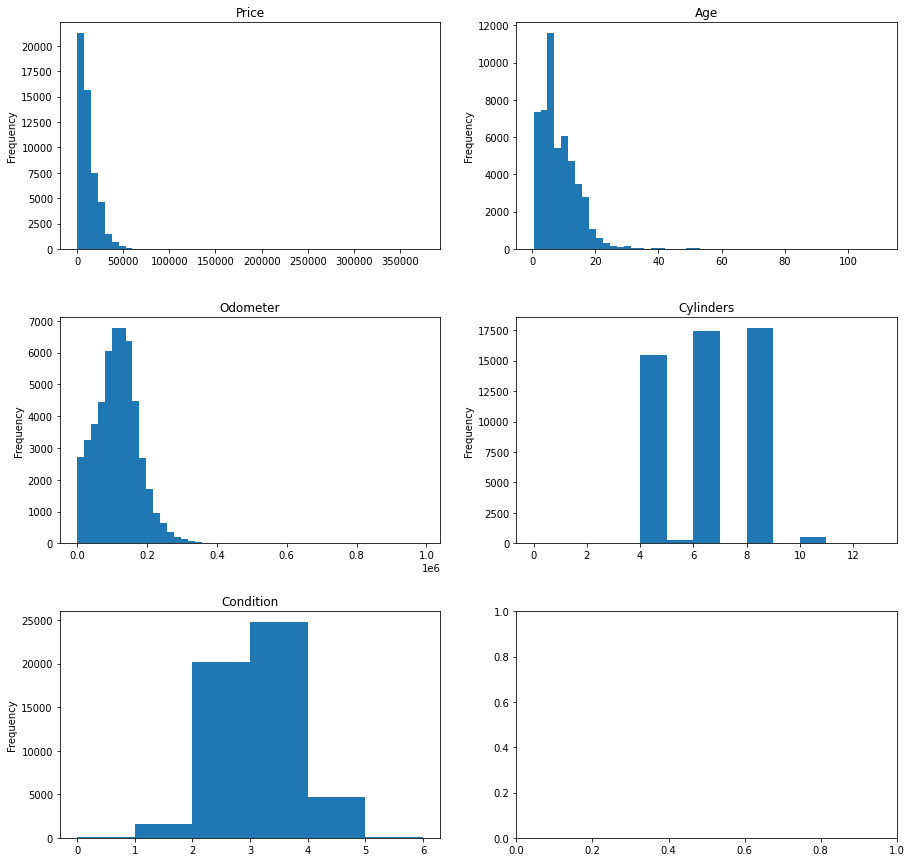

In [19]:
# plot histograms for values

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.3)

data['price'].plot(kind='hist', bins=50, title='Price', xlabel='Price', ylabel='Frequency', ax=axes[0, 0])
data['age'].plot(kind='hist', bins=50, title='Age', xlabel='Age', ylabel='Frequency', ax=axes[0, 1])
data['odometer'].plot(kind='hist', bins=50, title='Odometer', xlabel='Odometer', ylabel='Frequency', ax=axes[1, 0])
data['cylinders'].plot(kind='hist', bins=range(0, 14), title='Cylinders', xlabel='Cylinders', ylabel='Frequency', ax=axes[1, 1])
data['condition'].plot(kind='hist', bins=range(0, 7), title='Condition', xlabel='Condition', ylabel='Frequency', ax=axes[2, 0])

plt.show()

##### Conclusion <a name="step_4_1_conclusion"></a>

From these histograms, we can see that there are some extreme outliers in the **price**, **age**, and **odometer** columns that make the histogram quite difficult to read. We run into scaling problems where outliers cannot be accurately represented on the y-axis since their quantity is so small. This is true for all 5 histograms. We can also see a big spike in the **age** column from when we changed vehicle age from 0 to 1.

Histograms may not be the best visualization for the **cylinders** or **conditions** columns since the data range is much smaller. Almost all cars have either 4, 6, or 8 cylinders and fall into fair, good, excellent, or like new condition categories. Let's identify and filter out outliers to clean things up a bit.

#### Separating outliers <a name="step_4_2"></a>

In [20]:
# write function to create new DataFrames with good & bad data separated

def separate_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_rows = data.query('@column > (1.5 * @IQR) + @Q3')
    good_data_rows = data.query('@column <= (1.5 * @IQR) + @Q3')
    
    outliers = pd.DataFrame()
    good_data = pd.DataFrame()
    
    outliers = outliers.append(outlier_rows)
    good_data = good_data.append(good_data_rows)
    
    return outliers, good_data

In [21]:
# create new 'outliers' & 'good_data' DataFrames for each column using the function

columns = ['price', 'age', 'odometer']

for column_name in columns:
    exec(column_name + '_outliers' + ', ' + column_name + '_good_data' + ' = separate_outliers(data[column_name])')
    
    print('FILTERED ' + column_name.upper() + ' DATAFRAMES')
    print(column_name + '_outliers\n' + column_name + '_good_data\n')

FILTERED PRICE DATAFRAMES
price_outliers
price_good_data

FILTERED AGE DATAFRAMES
age_outliers
age_good_data

FILTERED ODOMETER DATAFRAMES
odometer_outliers
odometer_good_data



In [22]:
# describing outliers for these columns

def desc_outliers(column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    print(column.capitalize() + ' outliers are any value greater than {:.0f}'.format(1.5 * IQR + Q3))

for column in columns:
    desc_outliers(column)

Price outliers are any value greater than 34598
Age outliers are any value greater than 24
Odometer outliers are any value greater than 268766


#### Plot histograms with filtered data <a name="step_4_3"></a>

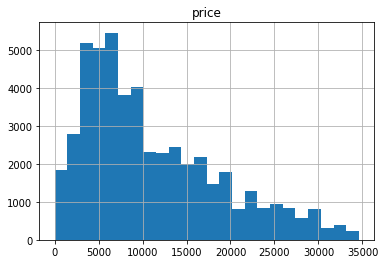

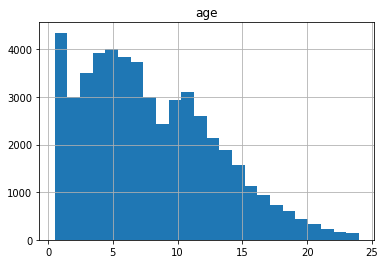

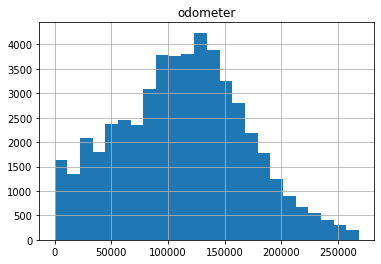

In [23]:
# plot 'price' data without outliers

price_good_data.hist('price', bins=24)
age_good_data.hist('age', bins=24)
odometer_good_data.hist('odometer', bins=24)
plt.show()

##### Conclusion <a name="step_4_3_conclusion"></a>

These histograms look much better. Removing outlier really helped with visualizing this data by only focusing on the meaningful portion. Now we can make some conclusions about each histogram.

Most car prices are beween 0 and 15,000. There is a long tail of data after the 15,000 mark. In general, more expensive cars are less common in this data set. The same can be said with age. Most cars are between 0 and 10 years old. Beyond 10 years, the number of cars begins to taper off. The mileage histogram has a different shape. Most cars have a moderate amount of mileage (75,000 to 175,000) with the rest falling into lower or higher mileage categories. Higher mileage vehicle counts taper off quickly, which is likely due to the failure rate of parts after a certain point in the vehicles life.

#### Correlations with number of days on market <a name="step_4_4"></a>

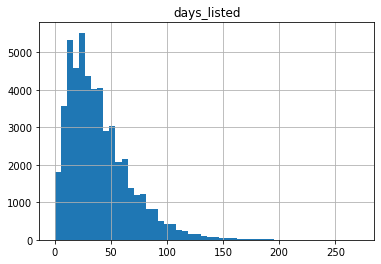

In [24]:
# plot a histogram of the 'days_listed' column

data.hist('days_listed', bins=50)
plt.show()

In [25]:
# finding mean, median, Q1, & Q3 for 'days_listed' column

print('Median # of days listed: {:.1f}'.format(data['days_listed'].mean()))
print('Mean # of days listed: {:.1f}'.format(data['days_listed'].median()))
print('Q1 for # of days listed: {:.1f}'.format(data['days_listed'].quantile(0.25)))
print('Q3 for # of days listed: {:.1f}'.format(data['days_listed'].quantile(0.75)))

Median # of days listed: 39.6
Mean # of days listed: 33.0
Q1 for # of days listed: 19.0
Q3 for # of days listed: 53.0


On average, cars in the data set sell within 30 to 40 days of the listing date. By looking at Q1 and Q3 for the **days_listed** column, we can conclude that ads listed for less than 19 days were removed quickly, and ads listed for over 53 days were listed for an abnormally long period of time. Let's see if there are any correlations between the time on market and things like the vehicle's price, mileage, age, and model.

In [26]:
# print correlation coefficient matrix for numerical columns

data.corr()

,price,model_year,condition,cylinders,odometer,is_4wd,days_listed,day_of_week_posted,month_posted,year_posted,age,mileage_per_year
price,1.000000,0.409735,0.221518,0.300448,-0.422749,0.315145,-0.000682,-0.000343,-0.005653,0.004726,-0.405984,0.223029
model_year,0.409735,1.000000,0.266701,-0.145540,-0.482860,0.039662,-0.005221,-0.007184,-0.010216,0.008398,-0.997117,0.476531
condition,0.221518,0.266701,1.000000,-0.065569,-0.291300,0.012856,-0.002404,0.001152,-0.002355,0.003788,-0.265071,0.080923
cylinders,0.300448,-0.145540,-0.065569,1.000000,0.090773,0.407433,0.003176,-0.003558,0.001593,-0.000373,0.146114,-0.035082
odometer,-0.422749,-0.482860,-0.291300,0.090773,1.000000,0.031209,0.002462,0.000842,0.009876,-0.007016,0.478358,0.010778
is_4wd,0.315145,0.039662,0.012856,0.407433,0.031209,1.000000,0.002003,0.003207,0.003891,-0.002476,-0.039063,0.049791
days_listed,-0.000682,-0.005221,-0.002404,0.003176,0.002462,0.002003,1.000000,0.002734,-0.011519,0.011273,0.005966,-0.006357
day_of_week_posted,-0.000343,-0.007184,0.001152,-0.003558,0.000842,0.003207,0.002734,1.000000,0.006457,-0.007476,0.006778,-0.002750
month_posted,-0.005653,-0.010216,-0.002355,0.001593,0.009876,0.003891,-0.011519,0.006457,1.000000,-0.818207,-0.050555,0.106304
year_posted,0.004726,0.008398,0.003788,-0.000373,-0.007016,-0.002476,0.011273,-0.007476,-0.818207,1.000000,0.065857,-0.127899


##### Conclusion <a name="step_4_4_conclusion"></a>

From above, we can see there is extremely low correlation between how old the vehicle listing is and all other numberical parameters. All values are close to zeros, meaning low correlation overall. Since there is no correlation with any of these other values, it's impossible to say with any certainty why ads stay listed for abnormally long or short times.

#### Number of ads vs Vehicle type <a name="step_4_5"></a>

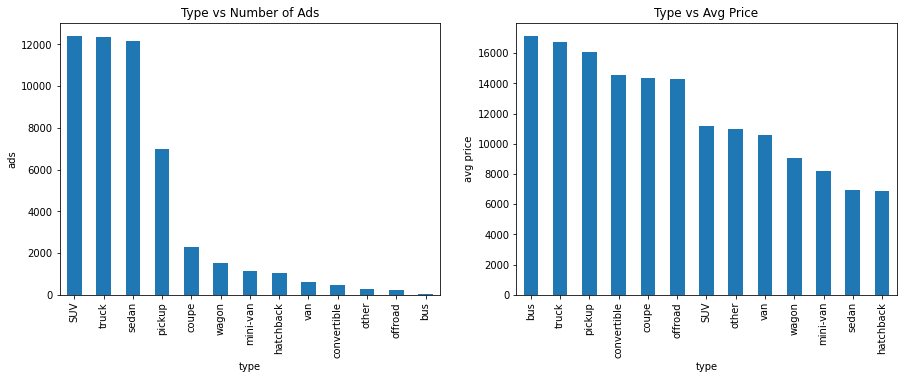

In [27]:
# number of ads for each vehicle type

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

type_by_ads = data['type'].value_counts()
type_by_ads.plot.bar(title='Type vs Number of Ads', xlabel='type', ylabel='ads', ax=axes[0])

type_by_avg_price = data.groupby('type')['price'].mean().sort_values(ascending=False)
type_by_avg_price.plot.bar(title='Type vs Avg Price', ylabel='avg price', ax=axes[1])
plt.show()

##### Conclusion <a name="step_4_5_conclusion"></a>

**SUVs** and **trucks** have the highest number of advertisements within this data set. **Buses** have the lowest number of ads. On average, **buses** fetch the highest price, followed by **trucks** and **convertibles**. If I were a salesman, I'd be focusing on selling trucks though. They have the highest number of ads and also fetch the highest price, and therefore a higher sales commission.

#### Factors that impact price <a name="step_4_6"></a>

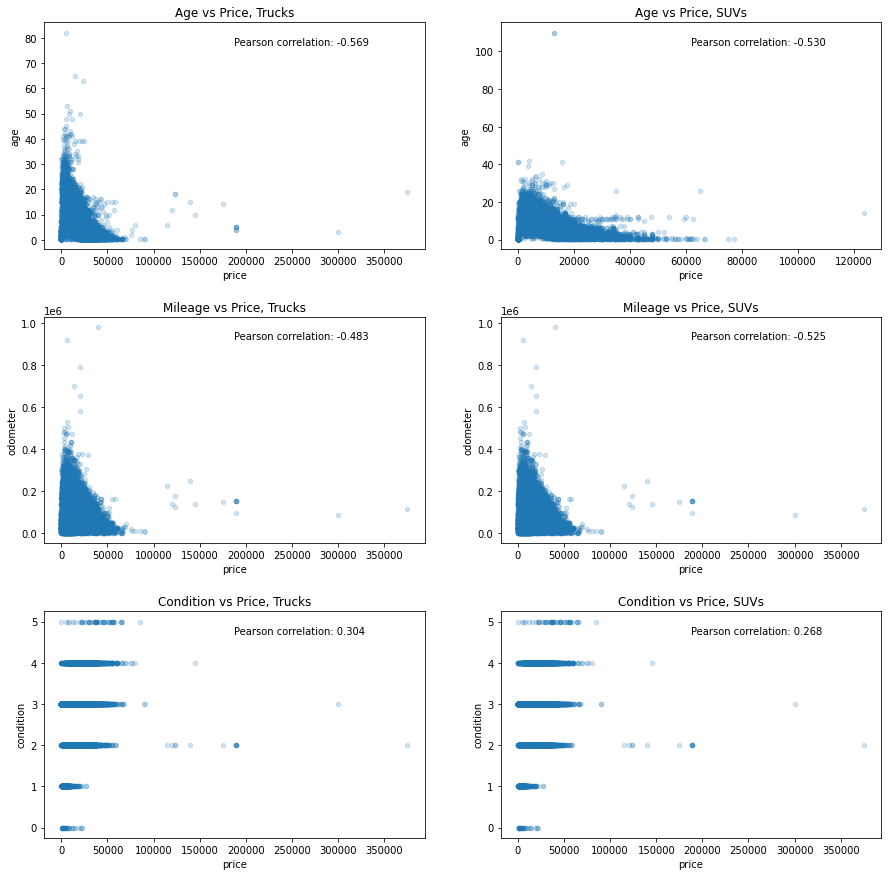

In [28]:
# define fig, axes for subplot

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.3)


# correlation with price for trucks

trucks = data.query('type == "truck" or type == "pickup"')

trucks.plot(x='price', y='age', kind='scatter', alpha=0.2, title='Age vs Price, Trucks', ax=axes[0, 0])
axes[0, 0].annotate(xy=(0.5, 0.9), text='Pearson correlation: {:.3f}'.format(trucks['price'].corr(trucks['age'])), xycoords='axes fraction')

trucks.plot(x='price', y='odometer', kind='scatter', alpha=0.2, title='Mileage vs Price, Trucks', ax=axes[1, 0])
axes[1, 0].annotate(xy=(0.5, 0.9), text='Pearson correlation: {:.3f}'.format(trucks['price'].corr(trucks['odometer'])), xycoords='axes fraction')

trucks.plot(x='price', y='condition', kind='scatter', alpha=0.2, title='Condition vs Price, Trucks', ax=axes[2, 0])
axes[2, 0].annotate(xy=(0.5, 0.9), text='Pearson correlation: {:.3f}'.format(trucks['price'].corr(trucks['condition'])), xycoords='axes fraction')


# correlation with price for SUVs

suvs = data.query('type == "SUV"')

suvs.plot(x='price', y='age', kind='scatter', alpha=0.2, title='Age vs Price, SUVs', ax=axes[0, 1])
axes[0, 1].annotate(xy=(0.5, 0.9), text='Pearson correlation: {:.3f}'.format(suvs['price'].corr(suvs['age'])), xycoords='axes fraction')

trucks.plot(x='price', y='odometer', kind='scatter', alpha=0.2, title='Mileage vs Price, SUVs', ax=axes[1, 1])
axes[1, 1].annotate(xy=(0.5, 0.9), text='Pearson correlation: {:.3f}'.format(suvs['price'].corr(suvs['odometer'])), xycoords='axes fraction')

trucks.plot(x='price', y='condition', kind='scatter', alpha=0.2, title='Condition vs Price, SUVs', ax=axes[2, 1])
axes[2, 1].annotate(xy=(0.5, 0.9), text='Pearson correlation: {:.3f}'.format(suvs['price'].corr(suvs['condition'])), xycoords='axes fraction')
plt.show()

It's clear from these scatter plots that the prices of SUVs and trucks are moderately correlated with the vehicle age, condition, and mileage. Age and mileage are negatively correlated, meaning that as age and mileage go up, price comes down. Vehicle condition is positively correlated, meaning as the condition of the vehicle improves, the price increases. Let's look at some of the categorical data.

In [29]:
# count number of cars for each color

data.paint_color.value_counts()

white     13835
black      9897
silver     7998
grey       5843
blue       4729
red        4705
green      1554
brown      1223
custom     1153
yellow      255
orange      231
purple      102
Name: paint_color, dtype: int64

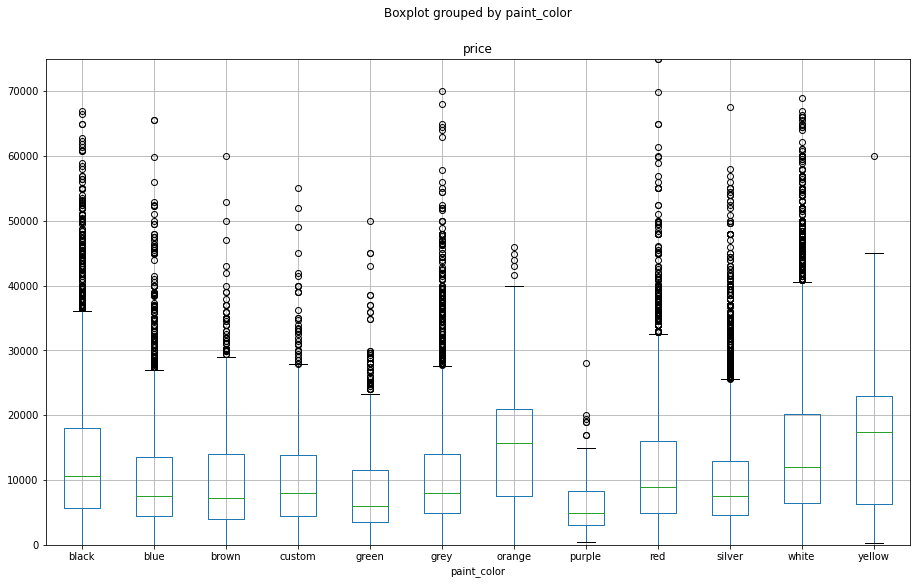

In [30]:
# boxplots of vehicle price grouped by paint color

data.boxplot(column='price', by='paint_color', figsize=(15, 9))
plt.ylim(0, 75000)
plt.show()

Black, orange, red, white and yellow cars appear to sell for higher prices than other colors. Purple cars sell for the lowest prices. Orange, yellow, and purple cars are pretty rare, however. This may limit the buyer's choices if we were to target these colors for sales. White and black cars account for most of the listings, so maybe it's a good idea to target black and white cars since it gives buyers a bigger choice and a bigger hole in their wallet, which transaltes to higher profit.

In [31]:
# count number of cars for each transmission type

data.transmission.value_counts()

automatic    46902
manual        2829
other         1794
Name: transmission, dtype: int64

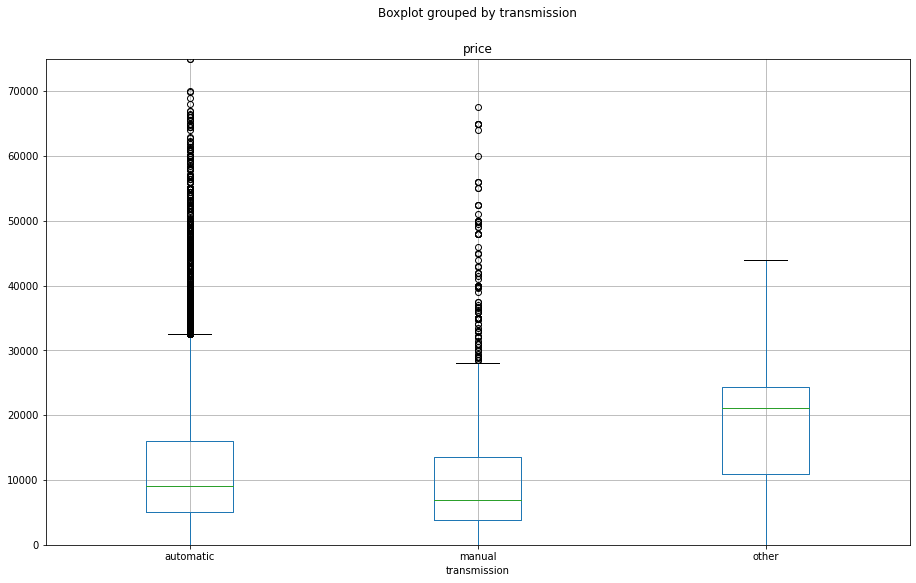

In [32]:
# boxplots of vehicle price grouped by transmission

data.boxplot(column='price', by='transmission', figsize=(15, 9))
plt.ylim(0, 75000)
plt.show()

Vehicle without automatic or manual transmissions sell for a higher price than either manual or automatic vehicles. Could these be all those fancy new electric vehicles? Automatics sell for slightly higher than manuals and in much larger quantities than the other two catgegories. It's probably more practical to target vehicles with automatic transmissions due to the sheer quantity of autos on the market. Unfortunately, manuals are a dying breed!

##### Conclusion <a name="step_4_6_conclusion"></a>

The ideal vehicle to sell would be a new black or white SUV or truck in good condition, with low mileage, 4wd, and automatic transmission. These vehicles statistically sell for higher prices, which translates to higher commissions for salesmen and higher profits for dealers.

### Step 5: Overall conclusion <a name="step_5"></a>

#### Initial glance at data
Upon opening the .csv file, we discovered there were 13 columns, each with 51,525 rows of data for a total of 669,825 cells. Columns initially consisted of string, integer, and float data types. Immediately we noticed missing values in a few columns which were later dealt with in the next step.

#### Replace missing data
We replaced missing values in the **model_year** and **paint_color** with the most comon values based on the vehicle model. **odometer** data was replaced with average mileage based on the model year. For the **cylinders** column, we used the number of cyliders for each vehicle as indicated by other rows. The **is_4wd** column had a simple error where missing values just needed to be changed to 0.

#### Change data types
We also changed data types from ***float*** to ***int*** and changed the **date_posted** column to the ***datetime*** data type for easier operations further into the project.

#### Add new calculations to DataFrame
Next, we made a few calculations to help analyze the data, and added them as new columns to the DataFrame. We replaced the 0 values from the new **age** column by 0.5 to prevent division by zero when creating the **mileage_per_year** column. We also replaced the **condition** column with values of a numerical scale from 0 to 5 so we could easily visualize and operate on this data.

#### Filter outliers & analyze histograms
Finally, we were able to carry out exploratory data analysis. First, we looked at some histograms for critical columns and discovered much of the data had outliers that needed to be accounted for. We created new DataFrames for the data, sorting into either outliers, or "good data" DataFrames. Then we plotted good data histograms and discovered some valuable insight once the ouliers were removed.

#### Days listed correlation analysis
We looked for any correlation between the number of days an ad stayed posted and any other data, but concluded that there were no significant factors that contributed to the length of time on the market.

#### Price & number of ads by vehicle type
Then we plotted bar charts showing number of ads by vehicle type and list price by vehicle type. We discovered that SUVs and trucks have both the most listings and sell for the highest prices. Building on that, we searched for any correlation between price and any other factors. Age and mileage are negatively correlated, while condition is positively correlated.

#### Pricing boxplots
As the final execise in EDA, we looked at boxplots of price grouped by paint color and price grouped by transmission. We discovered that black and white vehicles had higher number of listings and generally sold for more, and automatic transmissions were the most common and most practical to sell.

#### Suggestions
As a seller, marketer, or dealer, I would focus on the following segements of vehicles for sale as they command the highest price and also offer the customer the most choices and therefore are more likely to sell:

- new or excellent condition
- black or white paint
- SUV or truck
- low mileage
- 4wd with automatic transmission

